Lets take sklearn — make_classification dataset, train model on it and visualise results.

In [10]:
# https://github.com/Atcold/pytorch-Deep-Learning-Minicourse/blob/master/plot_lib.py

from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
import random
import torch
from torch import nn, optim
import numpy as np
import math
from IPython import display

# Data generation
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, 
                           n_clusters_per_class=1, n_classes=4)

# Less make some tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

D = X.shape[1]  # Input
H = 100  # Neurons in "hidden" layer
C = len(set(y.tolist()))  # Classes

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)

lambda_l2 = 0.00001
lr = 0.1
n_epochs = 1000
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=lambda_l2)

def make_train_step(model, loss_fn, optimizer):
    def train_step(X, y):
        model.train()
        yhat = model(X)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    loss = train_step(X, y)

print("Final loss:", loss)

Final loss: 0.09023793786764145


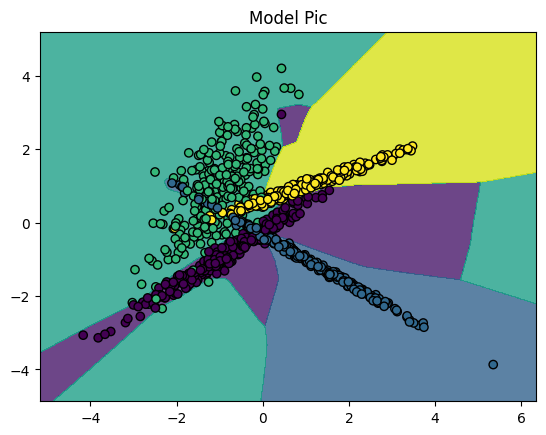

In [16]:
def plot_model(X, y, model, title="Model Pic"):
    X = X.cpu().numpy()
    y = y.cpu().numpy()
    xx, yy = np.meshgrid(np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, 0.01),
                         np.arange(X[:, 1].min() - 1, X[:, 1].max() + 1, 0.01))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        Z = model(grid).argmax(dim=1).cpu().numpy().reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.show()

plot_model(X, y, model)

This model is a basic neural network built for classifying data into four categories. It has an input layer that handles two features, a hidden layer with 100 neurons using ReLU activation to learn patterns, and an output layer that predicts the classes.

We trained it using CrossEntropyLoss which accounts for the error having a Gaussian distribution and the Adam optimizer.

---

Lets take a look on another alike model, but now with two hidden layers, and again we will visualise decision boundaries.

Epoch [100/1000], Loss: 0.4565
Epoch [200/1000], Loss: 0.4449
Epoch [300/1000], Loss: 0.4436
Epoch [400/1000], Loss: 0.4434
Epoch [500/1000], Loss: 0.4434
Epoch [600/1000], Loss: 0.4434
Epoch [700/1000], Loss: 0.4434
Epoch [800/1000], Loss: 0.4434
Epoch [900/1000], Loss: 0.4434
Epoch [1000/1000], Loss: 0.4434
Final loss: 0.44343259930610657


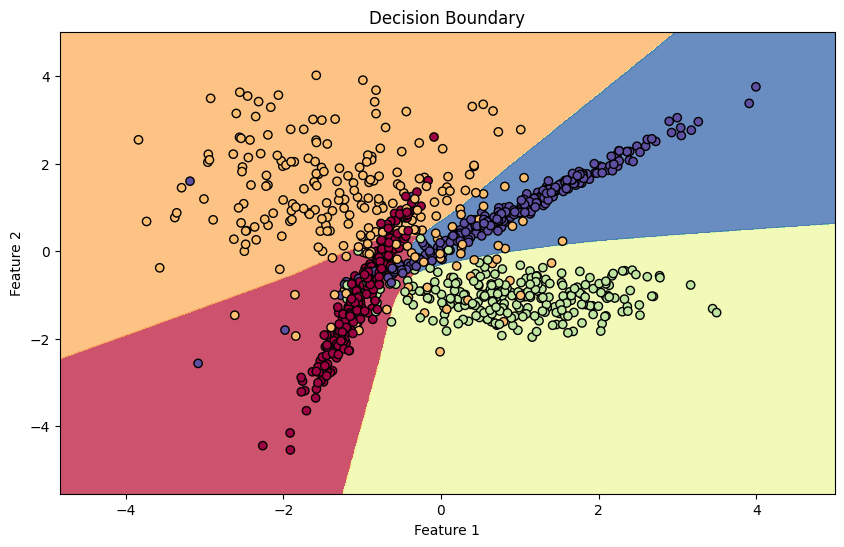

In [25]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification


X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, 
                           n_clusters_per_class=1, n_classes=4, random_state=42)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

input_size = X.shape[1]
hidden_size1 = 128
hidden_size2 = 64
num_classes = len(set(y.numpy()))

model = NeuralNetwork(input_size, hidden_size1, hidden_size2, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

num_epochs = 1000
X, y = X.to(device), y.to(device)

def train(model, criterion, optimizer, scheduler, num_epochs=1000):
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X)
        loss = criterion(outputs, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
            
    print("Final loss:", loss.item())

train(model, criterion, optimizer, scheduler, num_epochs)

def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
    with torch.no_grad():
        Z = model(grid).argmax(dim=1).cpu().numpy().reshape(xx.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.Spectral)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


X_cpu = X.cpu().numpy()
y_cpu = y.cpu().numpy()

plot_decision_boundary(model, X_cpu, y_cpu)